In [430]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.psl import plot
from neuromancer import psl

def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps #500
    length = (nsim//nsteps) * nsteps #1000
    ts = torch.linspace(0,1,nsteps)
    print('train sim ', train_sim['X'].shape)

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)

    print(trainX.shape)# N x nsteps x state_size 

    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_loader, dev_loader, test_data, trainX

In [376]:
ts

0.1

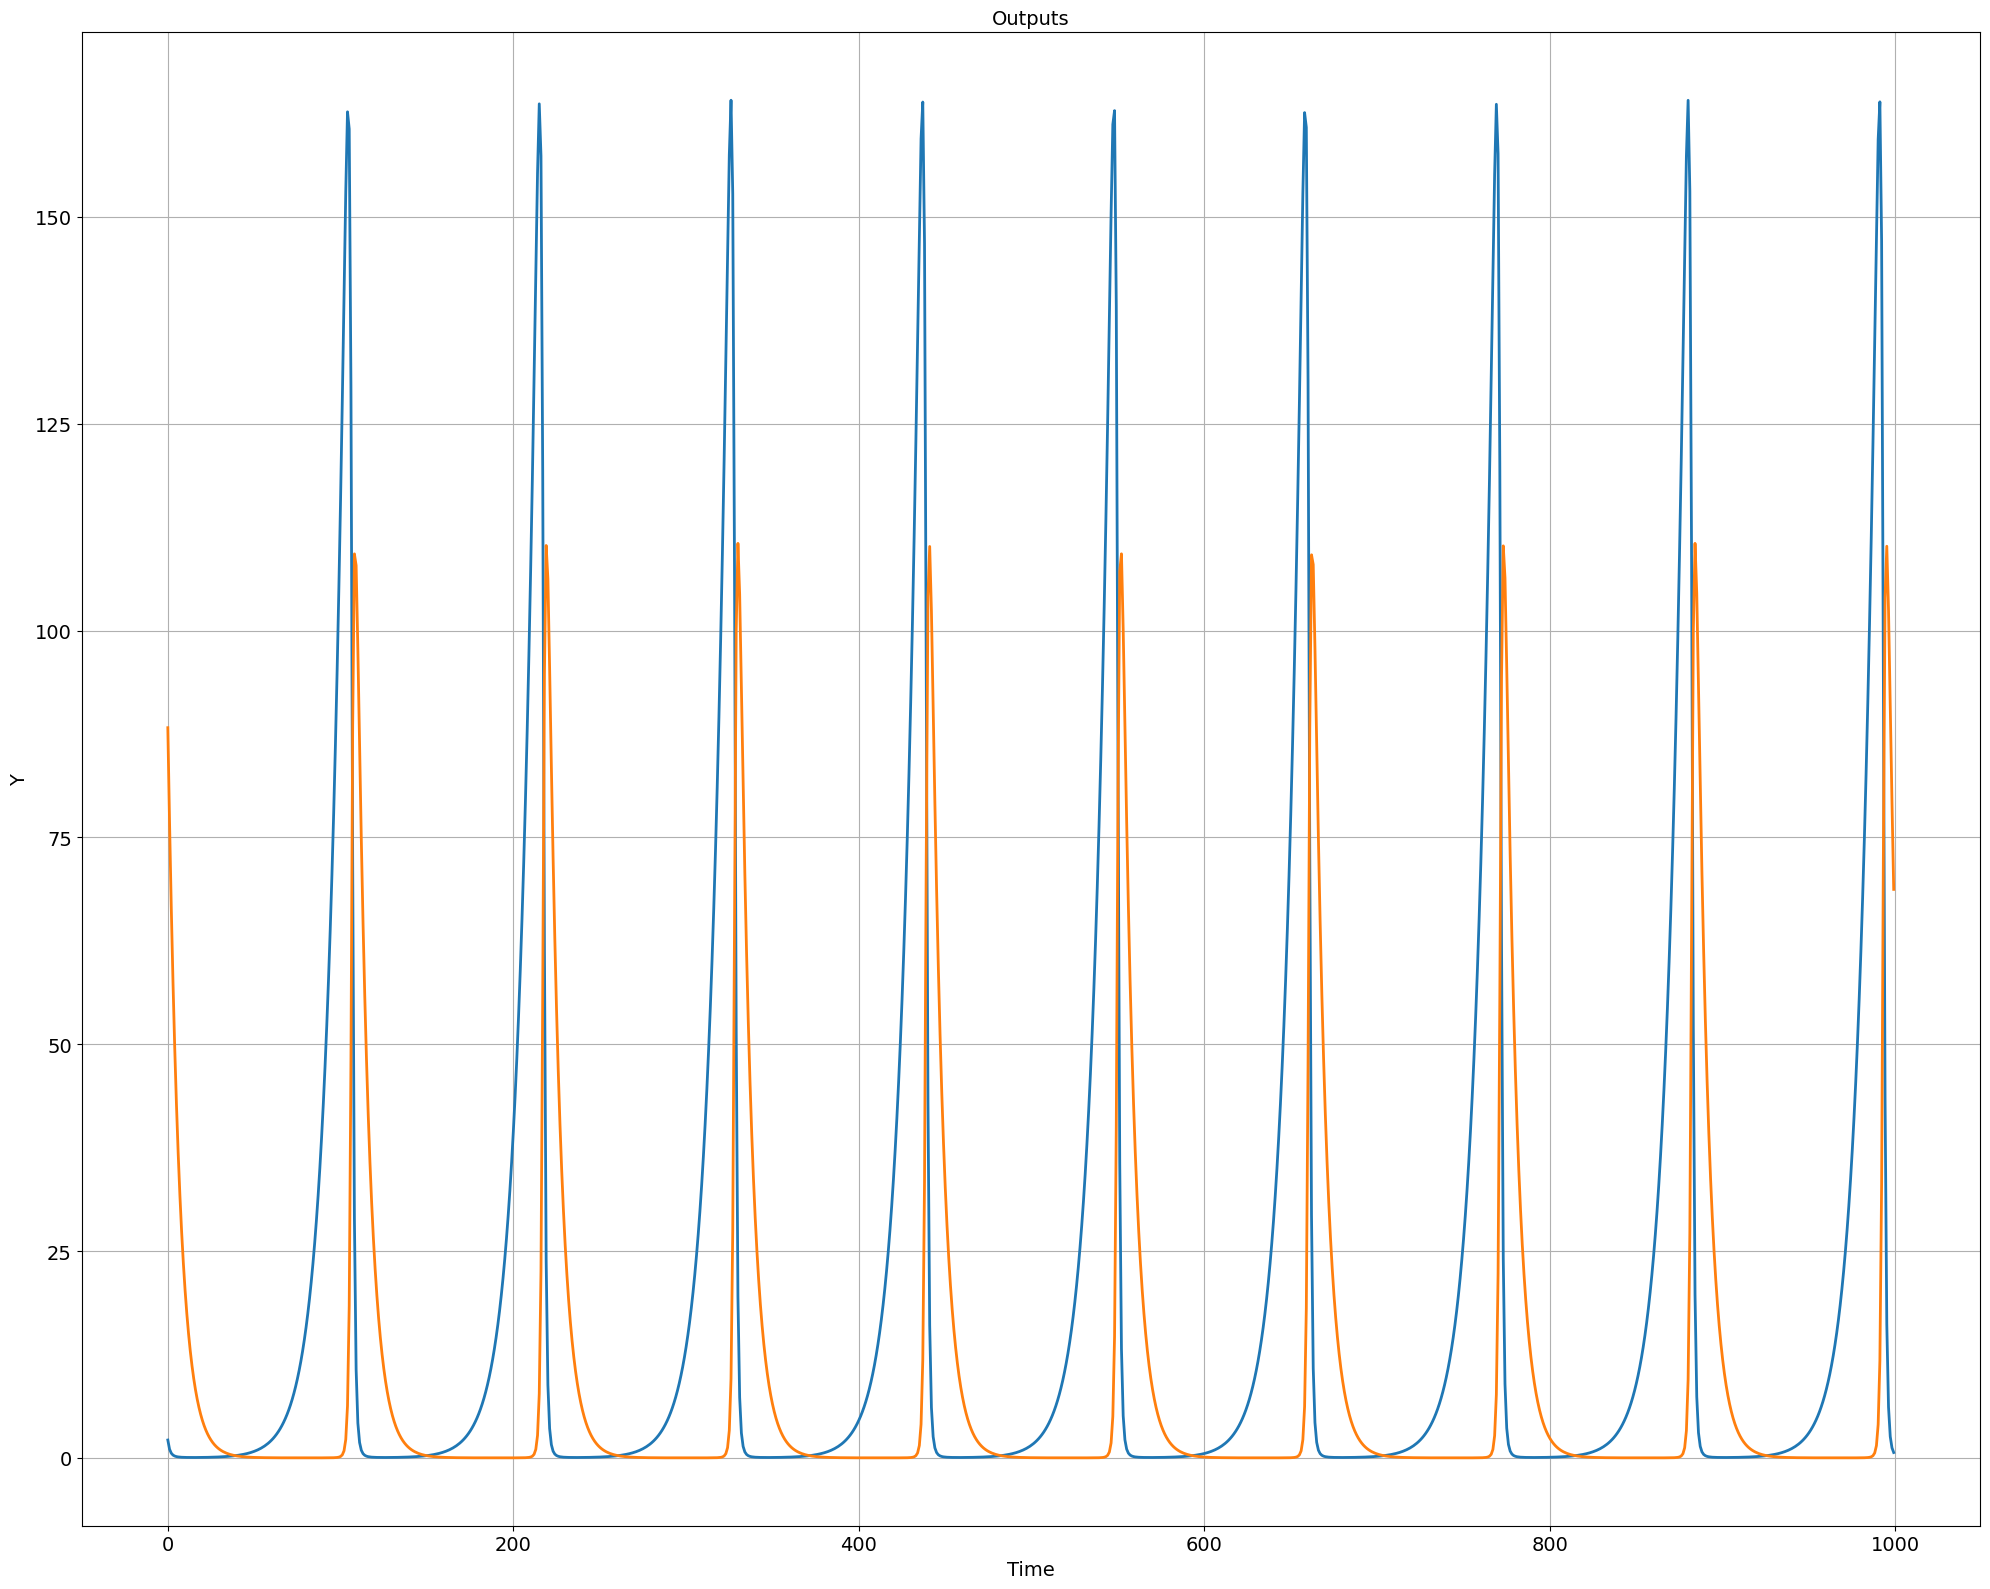

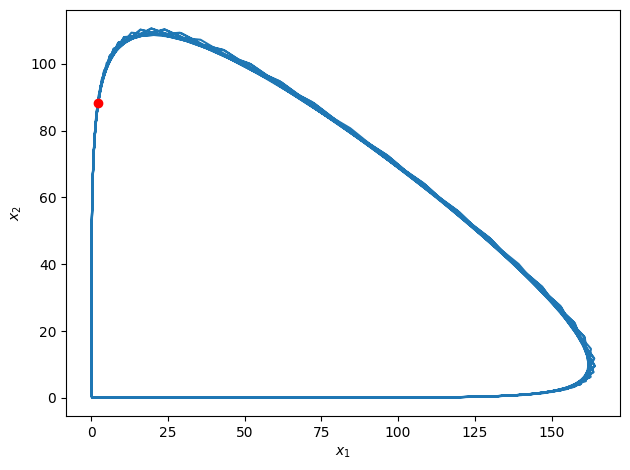

In [366]:
torch.manual_seed(0)

# %%  ground truth system
system = psl.systems['LotkaVolterra']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['X'])
plot.pltPhase(X=raw['Y'])

In [122]:
raw['Y'].shape

(1000, 2)

In [20]:
ts

0.1

In [152]:
class LotkaVolterraHybrid(ode.ODESystem):

    def __init__(self, block, insize=2, outsize=2):
        """

        :param block:
        :param insize:
        :param outsize:
        """
        super().__init__(insize=insize, outsize=outsize)
        self.block = block
        self.alpha = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.gamma = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        assert self.block.in_features == 2
        assert self.block.out_features == 1

    def ode_equations(self, x):
        x1 = x[:, [0]]
        x2 = x[:, [-1]]
        dx1 = self.alpha*x1 - self.beta*self.block(x)
        dx2 = self.delta*self.block(x) - self.gamma*x2
        return torch.cat([dx1, dx2], dim=-1)

In [431]:
nsim = 1000
nsteps = 2
bs = 10
train_loader, dev_loader, test_data, trainX = \
    get_data(modelSystem, nsim, nsteps, ts, bs)

# construct UDE model in Neuromancer
net = blocks.MLP(2, 1, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.GELU,
                    hsizes=4*[20])
fx = LotkaVolterraHybrid(net)
# integrate UDE model
#fxRK4 = integrators.RK4(fx, h=ts)
# create symbolic UDE model
#ude = Node(fxRK4, ['xn'], ['xn'], name='UDE')
#dynamics_model = System([ude])

train sim  (1000, 2)
torch.Size([500, 2, 2])


In [433]:
test_data['X'].shape

torch.Size([1, 1000, 2])

In [434]:
foo = next(iter(train_loader))['xn'].shape
foo

torch.Size([10, 1, 2])

In [429]:
train_loader, dev_loader, test_data = \
    get_data(modelSystem, nsim, nsteps, ts, bs)



train sim  (2000, 2)
torch.Size([1000, 2, 2])


ValueError: too many values to unpack (expected 3)

In [236]:
test_data['X'].shape

torch.Size([1, 1000, 2])

In [235]:
foo['X'].shape

torch.Size([10, 2, 2])

In [185]:
foo = next(iter(train_loader))
baz = dynamics_model(foo)
crow = baz['xn'][:, :-1, :]
zee = foo['X']
crow.shape

torch.Size([10, 2, 2])

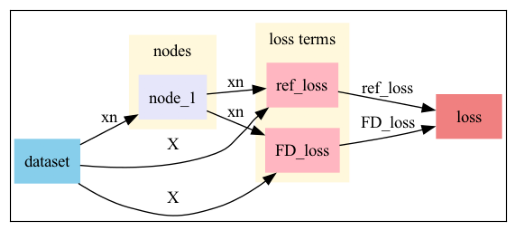

epoch: 0  train_loss: 132.47061157226562
epoch: 1  train_loss: 131.7687530517578
epoch: 2  train_loss: 129.95571899414062
epoch: 3  train_loss: 125.45148468017578
epoch: 4  train_loss: 116.02897644042969
epoch: 5  train_loss: 103.9565200805664
epoch: 6  train_loss: 88.39973449707031
epoch: 7  train_loss: 68.98637390136719
epoch: 8  train_loss: 48.9209098815918
epoch: 9  train_loss: 33.7833366394043
epoch: 10  train_loss: 22.572431564331055
epoch: 11  train_loss: 15.94296646118164
epoch: 12  train_loss: 12.417157173156738
epoch: 13  train_loss: 10.783241271972656
epoch: 14  train_loss: 10.143138885498047
epoch: 15  train_loss: 9.486162185668945
epoch: 16  train_loss: 9.16718864440918
epoch: 17  train_loss: 8.65892505645752
epoch: 18  train_loss: 8.216514587402344
epoch: 19  train_loss: 7.985803604125977
epoch: 20  train_loss: 7.507031440734863
epoch: 21  train_loss: 7.135715484619141
epoch: 22  train_loss: 6.752894401550293
epoch: 23  train_loss: 6.697210311889648
epoch: 24  train_loss:

<All keys matched successfully>

In [203]:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# trajectory tracking loss
reference_loss = (xhat == x)^2
reference_loss.name = "ref_loss"

# finite difference variables
xFD = (x[:, 1:, :] - x[:, :-1, :])
xhatFD = (xhat[:, 1:, :] - xhat[:, :-1, :])

# finite difference loss
fd_loss = 2.0*((xFD == xhatFD)^2)
fd_loss.name = 'FD_loss'

# %%
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)
# plot computational graph
problem.show()

# %%
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=5000,
    warmup=5000,
    epochs=500,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    device='cpu'
)
# %%
best_model = trainer.train()
problem.load_state_dict(best_model)

Learned parameter a= 0.10000000149011612
Learned parameter b= 0.10000000149011612
Learned parameter c= 0.10000000149011612
Learned parameter d= 0.10000000149011612
True parameter a= 1.0
True parameter b= 0.10000000149011612
True parameter c= 1.5
True parameter d= 0.75


ValueError: Batch sizes not consistent.

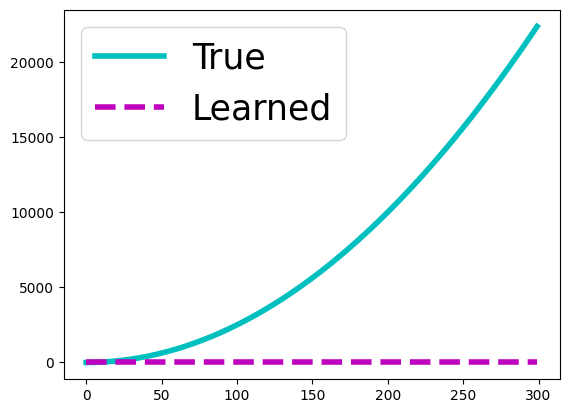

In [361]:
print('Learned parameter a=', float(fx.alpha))
print('Learned parameter b=', float(fx.beta))
print('Learned parameter c=', float(fx.gamma))
print('Learned parameter d=', float(fx.delta))

print('True parameter a=', float(modelSystem.a))
print('True parameter b=', float(modelSystem.b))
print('True parameter c=', float(modelSystem.c))
print('True parameter d=', float(modelSystem.d))

# evaluate learned black box block
x1 = torch.arange(0., 150., 0.5)
x2 = torch.arange(0., 150., 0.5)
true_block = x1*x2
learned_block = net(torch.stack([x1, x2]).T).squeeze()
plt.figure()
plt.plot(true_block.detach().numpy(), 'c',
            linewidth=4.0, label='True')
plt.plot(learned_block.detach().numpy(), 'm--',
            linewidth=4.0, label='Learned')
plt.legend(fontsize=25)

# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :]
true_traj = test_data['X']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [233]:
test_data

{'X': tensor([[[ 2.1548, 88.2591],
          [ 1.0439, 76.8354],
          [ 0.5640, 66.5173],
          ...,
          [ 2.5745, 90.9051],
          [ 1.2156, 79.3024],
          [ 0.6416, 68.7135]]]),
 'xn': tensor([[[ 2.1548, 88.2591]]])}

In [213]:
class LotkaVolterraHybrid(ode.ODESystem):

    def __init__(self, block, insize=2, outsize=2):
        """

        :param block:
        :param insize:
        :param outsize:
        """
        super().__init__(insize=insize, outsize=outsize)
        self.block = block
        self.alpha = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.gamma = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        assert self.block.in_features == 2
        assert self.block.out_features == 1

    def ode_equations(self, x):
        x1 = x[:, [0]]
        x2 = x[:, [-1]]
        dx1 = self.alpha*x1 - self.beta*self.block(x)
        dx2 = self.delta*self.block(x) - self.gamma*x2
        return torch.cat([dx1, dx2], dim=-1)

In [228]:
import torchsde

class LotkaVolterraSDE(nn.Module):
    def __init__(self, block, insize=2, outside=2, noise_type="diagonal"):
        super().__init__()
        self.block = block 
        self.alpha = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.gamma = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.in_features = 0
        self.out_features = 0
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, y):

        x1 = y[:, [0]]
        x2 = y[:, [-1]]

        dx1 = self.alpha*x1 - self.beta*self.block(y)
        dx2 = self.delta*self.block(y) - self.gamma*x2

        return torch.cat([dx1, dx2], dim=-1)

    def g(self, t, y):
        return torch.zeros(10, 2)

# construct UDE model in Neuromancer
net = blocks.MLP(2, 1, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.GELU,
                    hsizes=4*[20])
fx = LotkaVolterraSDE(block=net)


class BasicSDEIntegrator(integrators.Integrator): 
    """
    Integrator (from TorchSDE) for basic/explicit SDE case where drift (f) and diffusion (g) terms are defined 
    Returns a single tensor of size (t, batch_size, state_size).

    Please see https://github.com/google-research/torchsde/blob/master/torchsde/_core/sdeint.py
    Currently only supports Euler integration. Choice of integration method is dependent 
    on integral type (Ito/Stratanovich) and drift/diffusion terms
    """
    def __init__(self, block, numsteps ): 
        """
        :param block: (nn.Module) The BasicSDE block
        """
        super().__init__(block) 
        self.numsteps = numsteps 

    def integrate(self, x): 
        """
        x is the initial datastate of size (batch_size, state_size)
        t is the time-step vector over which to integrate
        """
        t = torch.tensor([0.,0.1, 0.2], dtype=torch.float32)
        x = x.squeeze(1) #remove time step 
  
        ys = torchsde.sdeint(self.block, x, t, method='euler')
        ys = ys.permute(1, 0, 2)
        return ys 

integrator = BasicSDEIntegrator(fx, numsteps=2) 
# integrate UDE model
# create symbolic UDE model
model = Node(integrator, input_keys=['xn'], output_keys=['xn'])
dynamics_model = model


In [238]:
test_data['xn'].shape

torch.Size([1, 1, 2])

In [237]:
foo['xn'].shape

torch.Size([10, 1, 2])

In [226]:
foo = next(iter(train_loader))

baz = dynamics_model(foo)
baz['xn'].shape

torch.Size([10, 3, 2])

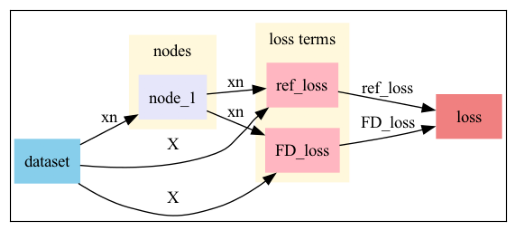

epoch: 0  train_loss: 133.12298583984375
epoch: 1  train_loss: 132.64720153808594
epoch: 2  train_loss: 130.9735565185547
epoch: 3  train_loss: 126.02873229980469
epoch: 4  train_loss: 118.0386734008789
epoch: 5  train_loss: 113.14652252197266
epoch: 6  train_loss: 110.42718505859375
epoch: 7  train_loss: 104.79252624511719
epoch: 8  train_loss: 100.4343032836914
epoch: 9  train_loss: 96.34988403320312
epoch: 10  train_loss: 87.50508880615234
epoch: 11  train_loss: 81.53534698486328
epoch: 12  train_loss: 73.87696838378906
epoch: 13  train_loss: 64.91850280761719
epoch: 14  train_loss: 57.168968200683594
epoch: 15  train_loss: 49.983306884765625
epoch: 16  train_loss: 41.7336311340332
epoch: 17  train_loss: 35.65283203125
epoch: 18  train_loss: 29.61258316040039
epoch: 19  train_loss: 22.141714096069336
epoch: 20  train_loss: 15.57487678527832
epoch: 21  train_loss: 10.8868989944458
epoch: 22  train_loss: 8.614974975585938
epoch: 23  train_loss: 8.053958892822266
epoch: 24  train_loss:

<All keys matched successfully>

In [230]:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# trajectory tracking loss
reference_loss = (xhat == x)^2
reference_loss.name = "ref_loss"



# finite difference loss
fd_loss = 2.0*((xFD == xhatFD)^2)
fd_loss.name = 'FD_loss'

# %%
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)
# plot computational graph
problem.show()

# %%
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=50,
    warmup=0,
    epochs=50,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    device='cpu', 
    epoch_verbose=1
)
# %%
best_model = trainer.train()
problem.load_state_dict(best_model)


Learned parameter a= 0.7175129055976868
Learned parameter b= 0.33722737431526184
Learned parameter c= 1.1291733980178833
Learned parameter d= 0.24657443165779114
True parameter a= 1.0
True parameter b= 0.10000000149011612
True parameter c= 1.5
True parameter d= 0.75


ValueError: Batch sizes not consistent.

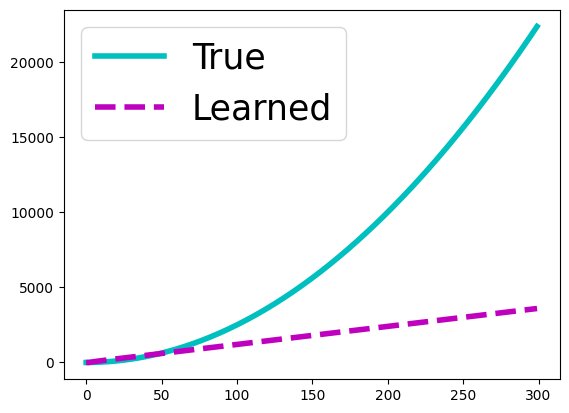

In [243]:
print('Learned parameter a=', float(fx.alpha))
print('Learned parameter b=', float(fx.beta))
print('Learned parameter c=', float(fx.gamma))
print('Learned parameter d=', float(fx.delta))

print('True parameter a=', float(modelSystem.a))
print('True parameter b=', float(modelSystem.b))
print('True parameter c=', float(modelSystem.c))
print('True parameter d=', float(modelSystem.d))

# evaluate learned black box block
x1 = torch.arange(0., 150., 0.5)
x2 = torch.arange(0., 150., 0.5)
true_block = x1*x2
learned_block = net(torch.stack([x1, x2]).T).squeeze()
plt.figure()
plt.plot(true_block.detach().numpy(), 'c',
            linewidth=4.0, label='True')
plt.plot(learned_block.detach().numpy(), 'm--',
            linewidth=4.0, label='Learned')
plt.legend(fontsize=25)

# Test set results
new_test_data = test_data['xn']
new_test_data_dict = {'xn': new_test_data}
test_outputs = dynamics_model(new_test_data_dict)
print("HI")

pred_traj = test_outputs['xn'][:, :-1, :]
true_traj = test_data['X']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [174]:
www = problem(foo)
www.keys()

dict_keys(['train_X', 'train_xn', 'train_name', 'train_140361679634384', 'train_140361679634384_eq_X', 'train_140361679634384_eq_X_value', 'train_140361679634384_eq_X_violation', 'train_objective_loss', 'train_penalty_loss', 'train_loss'])

In [218]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    ts = torch.linspace(0,1,nsteps)

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)



    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :]}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :]}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nsim, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :]}

    return train_data, dev_data, test_data, bs

In [229]:
from neuromancer.trainer import Trainer, LitTrainer
lit_trainer = LitTrainer(epochs=50, accelerator='cpu', train_metric='train_loss', 
                         dev_metric='dev_loss', eval_metric='dev_loss', test_metric='dev_loss', custom_optimizer=optimizer)



lit_trainer.fit(problem=problem, data_setup_function=get_data,  sys=modelSystem, nsim=nsim, nsteps=nsteps, ts=ts, bs=bs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment.  If you were attempting to deepcopy a module, this may be because of a torch.nn.utils.weight_norm usage, see https://github.com/pytorch/pytorch/pull/103001

## Generate Stochastic Lotka Volterra System Data

In [420]:
# Define the Lotka-Volterra SDE
class LotkaVolterraSDE(nn.Module):
    def __init__(self, a, b, c, d, sigma1, sigma2):
        super().__init__()
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, x):
        x1 = x[:,[0]]
        x2 = x[:,[1]]
        dx1 = self.a * x1 - self.b * x1*x2
        dx2 = self.c * x1*x2 - self.d * x2
        foo = torch.cat([dx1, dx2], dim=-1)
        print("FOO SHAPE ", foo.shape)
        return torch.cat([dx1, dx2], dim=-1)

    def g(self, t, x):
        sigma_diag = torch.tensor([[self.sigma1, self.sigma2]])
        return sigma_diag #[batch_size x state size ]

# Define parameters
a = 1.1    # Prey growth rate
b = 0.4   # Predation rate
c = 0.1   # Predator growth rate
d = 0.4   # Predator death rate
sigma1 = 1
sigma2 = 0

# Create the SDE model
sde = LotkaVolterraSDE(a, b, c, d, sigma1, sigma2)


# Define time span
t_span = torch.linspace(0, 20, 2000)

# Initial condition
x0 = torch.tensor([10.0, 10.0]).unsqueeze(0) #[1x2]


# Integrate the SDE model
sol_train = torchsde.sdeint(sde, x0, t_span, method='euler')
sol_dev = torchsde.sdeint(sde, x0, t_span, method='euler')
sol_test = torchsde.sdeint(sde, x0, t_span, method='euler')




FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE  torch.Size([1, 2])
FOO SHAPE 

KeyboardInterrupt: 

In [378]:
t_span[1] - t_span[0]

tensor(0.0100)

In [369]:
sol.shape

torch.Size([2000, 1, 2])

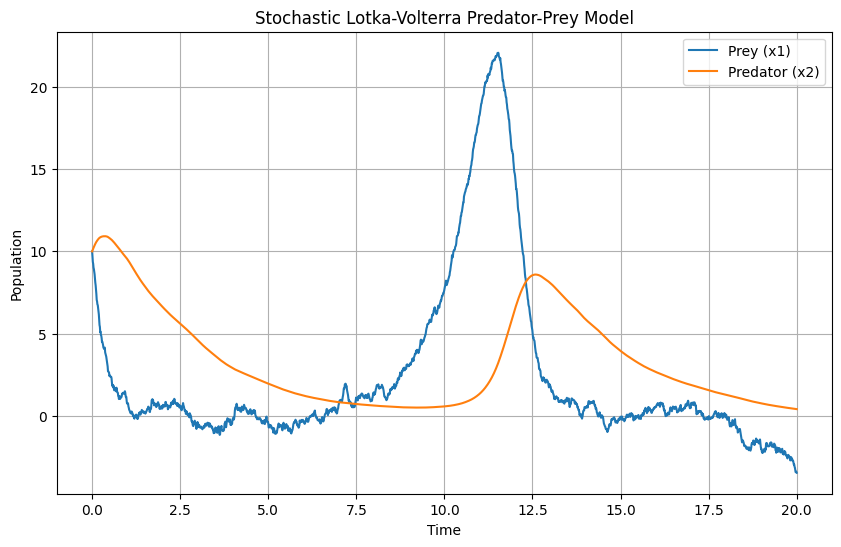

In [421]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, sol_train[:, 0,0], label='Prey (x1)')
plt.plot(t_span, sol_train[:,0, 1], label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Stochastic Lotka-Volterra Predator-Prey Model')
plt.legend()
plt.grid(True)
plt.show()

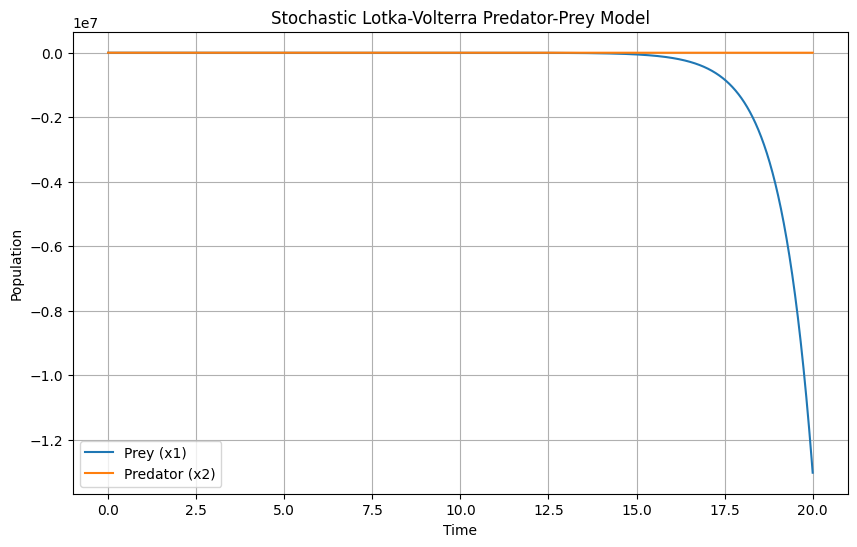

In [385]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, sol_dev[:, 0,0], label='Prey (x1)')
plt.plot(t_span, sol_dev[:,0, 1], label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Stochastic Lotka-Volterra Predator-Prey Model')
plt.legend()
plt.grid(True)
plt.show()

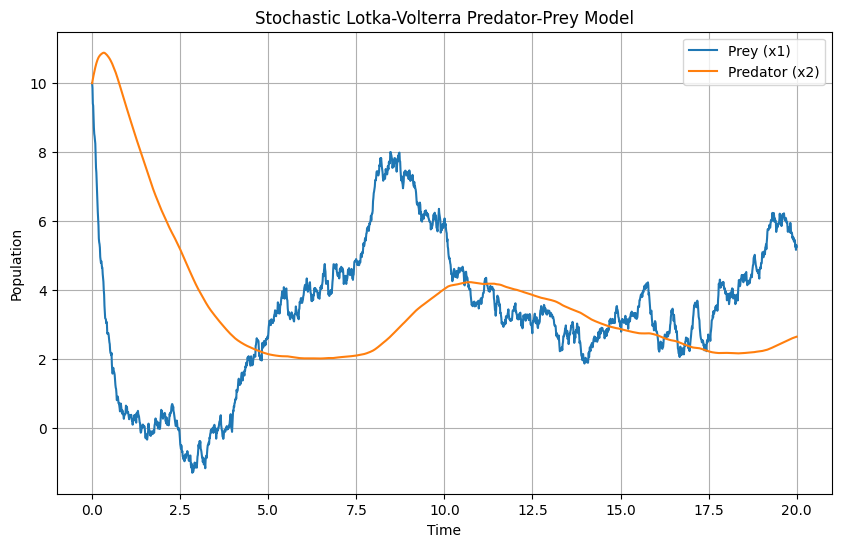

In [422]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, sol_test[:, 0,0], label='Prey (x1)')
plt.plot(t_span, sol_test[:,0, 1], label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Stochastic Lotka-Volterra Predator-Prey Model')
plt.legend()
plt.grid(True)
plt.show()

In [439]:
nx = 2
nsim = 2000
nsteps = 2
nbatch = nsim//nsteps
length = (nsim//nsteps) * nsteps
bs = 10
x_train_lvs = sol_train.squeeze(1)[:length].reshape(nbatch, nsteps, nx)
train_data_lvs = DictDataset({'X': x_train_lvs, 'xn': x_train_lvs[:, 0:1, :]}, name='train')
train_loader_lvs = DataLoader(train_data_lvs, batch_size=bs,
                            collate_fn=train_data_lvs.collate_fn, shuffle=True)

x_dev_lvs = sol_test.squeeze(1)[:length].reshape(nbatch, nsteps, nx)
dev_data_lvs = DictDataset({'X': x_dev_lvs, 'xn': x_dev_lvs[:, 0:1, :]}, name='dev')
dev_loader_lvs = DataLoader(dev_data_lvs, batch_size=bs,
                            collate_fn=dev_data_lvs.collate_fn, shuffle=True)

x_test_lvs = sol_test.squeeze(1)[:length].reshape(1, nsim, nx)
test_data_lvs = DictDataset({'X': x_test_lvs, 'xn': x_test_lvs[:, 0:1, :]}, name='test')
test_data_lvs_2 = {'X': x_test_lvs, 'xn': x_test_lvs[:, 0:1, :]}

In [444]:
test_data_lvs_2['xn'].shape

torch.Size([1, 1, 2])

## Train SDE on this system

In [397]:
class LotkaVolterraSDE(nn.Module):
    def __init__(self, block, insize=2, outside=2, noise_type="diagonal"):
        super().__init__()
        self.block = block 
        self.alpha = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.beta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.delta = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.gamma = nn.Parameter(torch.tensor([.10]), requires_grad=True)
        self.g_params = nn.Parameter(torch.randn(10, 2), requires_grad=True)  # Learnable parameters
        self.in_features = 0
        self.out_features = 0
        self.noise_type = "diagonal"
        self.sde_type = "ito"

    def f(self, t, y):

        x1 = y[:, [0]]
        x2 = y[:, [-1]]

        dx1 = self.alpha*x1 - self.beta*self.block(y)
        dx2 = self.delta*self.block(y) - self.gamma*x2

        return torch.cat([dx1, dx2], dim=-1)

    def g(self, t, y):
        return self.g_params

# construct UDE model in Neuromancer
net = blocks.MLP(2, 1, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.GELU,
                    hsizes=4*[20])
fx = LotkaVolterraSDE(block=net)


class BasicSDEIntegrator(integrators.Integrator): 
    """
    Integrator (from TorchSDE) for basic/explicit SDE case where drift (f) and diffusion (g) terms are defined 
    Returns a single tensor of size (t, batch_size, state_size).

    Please see https://github.com/google-research/torchsde/blob/master/torchsde/_core/sdeint.py
    Currently only supports Euler integration. Choice of integration method is dependent 
    on integral type (Ito/Stratanovich) and drift/diffusion terms
    """
    def __init__(self, block ): 
        """
        :param block: (nn.Module) The BasicSDE block
        """
        super().__init__(block) 


    def integrate(self, x): 
        """
        x is the initial datastate of size (batch_size, state_size)
        t is the time-step vector over which to integrate
        """
        t = torch.tensor([0.,0.01, 0.02], dtype=torch.float32)
        x = x.squeeze(1) #remove time step 
  
        ys = torchsde.sdeint(self.block, x, t, method='euler')
        ys = ys.permute(1, 0, 2)
        return ys 

integrator = BasicSDEIntegrator(fx) 
# integrate UDE model
# create symbolic UDE model
model_sde = Node(integrator, input_keys=['xn'], output_keys=['xn'])
dynamics_model_sde = model

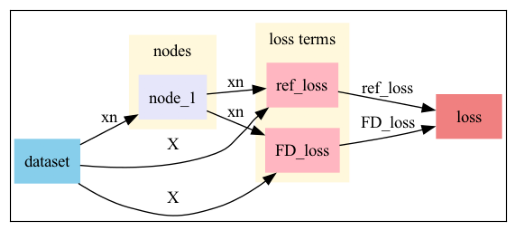

epoch: 0  train_loss: 0.023017268627882004
epoch: 1  train_loss: 0.018558792769908905
epoch: 2  train_loss: 0.016840744763612747
epoch: 3  train_loss: 0.0161198228597641
epoch: 4  train_loss: 0.015907132998108864
epoch: 5  train_loss: 0.01590757444500923
epoch: 6  train_loss: 0.01598076894879341
epoch: 7  train_loss: 0.015865400433540344
epoch: 8  train_loss: 0.015806077048182487
epoch: 9  train_loss: 0.0158010795712471
epoch: 10  train_loss: 0.015765946358442307
epoch: 11  train_loss: 0.0157708078622818
epoch: 12  train_loss: 0.01589883863925934
epoch: 13  train_loss: 0.0157649964094162
epoch: 14  train_loss: 0.015724308788776398
epoch: 15  train_loss: 0.015662459656596184
epoch: 16  train_loss: 0.015650611370801926
epoch: 17  train_loss: 0.015621047466993332
epoch: 18  train_loss: 0.015543315559625626
epoch: 19  train_loss: 0.015556756407022476
epoch: 20  train_loss: 0.015441193245351315
epoch: 21  train_loss: 0.015387657098472118
epoch: 22  train_loss: 0.015203121118247509
epoch: 23

<All keys matched successfully>

In [398]:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# trajectory tracking loss
reference_loss = (xhat == x)^2
reference_loss.name = "ref_loss"



# finite difference loss
fd_loss = 2.0*((xFD == xhatFD)^2)
fd_loss.name = 'FD_loss'

# %%
objectives = [reference_loss, fd_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model_sde], loss)
# plot computational graph
problem.show()

# %%
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)
trainer = Trainer(
    problem,
    train_loader_lvs,
    dev_loader_lvs,
    test_data_lvs,
    optimizer,
    patience=50,
    warmup=0,
    epochs=50,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    device='cpu', 
    epoch_verbose=1
)
# %%
best_model = trainer.train()
problem.load_state_dict(best_model)

In [426]:
foo = next(iter(train_loader_lvs))
foo['xn'].shape

torch.Size([10, 1, 2])

In [425]:
test_data_lvs_2['xn'].shape

torch.Size([1000, 1, 2])

In [427]:
test_outputs = dynamics_model_sde(test_data_lvs_2)


ValueError: Batch sizes not consistent.

In [415]:
true_traj = test_data_lvs_2['X'].detach().numpy().reshape(-1, 2)